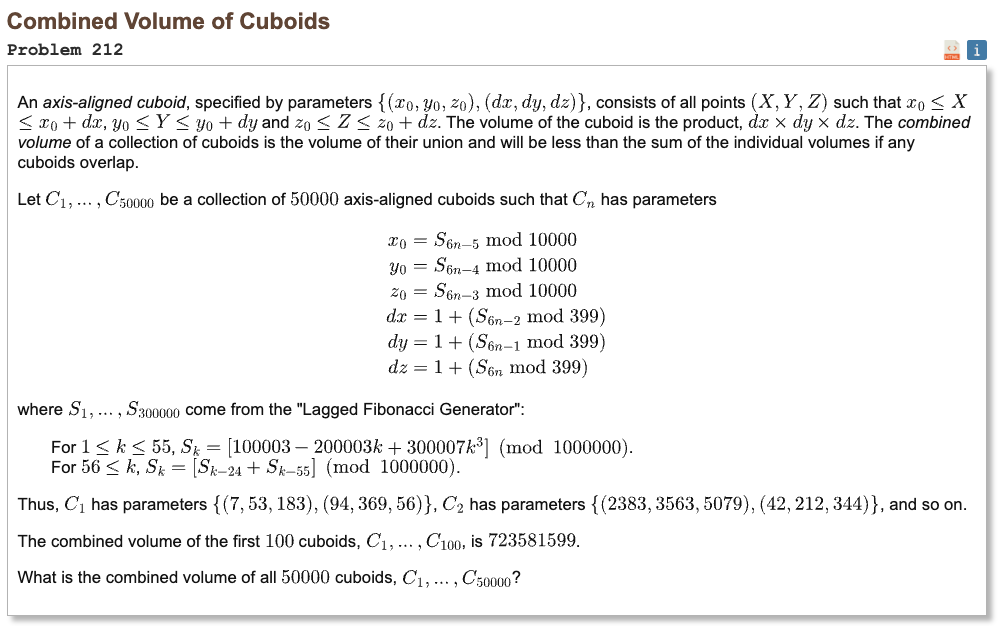

## Initial approach

* generate the 300000 lagged fibonacci values and turn them into 50000 cuboids with x0,y0,z0 in 0..9999 and side lengths in 1..399
* treat each cuboid as half open ranges [x0,x1) [y0,y1) [z0,z1) since boundaries do not change volume
* sweep along x using events, at x0 a cuboid becomes active, at x1 it stops being active
* for each x slab between consecutive x event positions, compute the union area of the active rectangles in the yz plane
* compute that yz union area with a y sweep and a segment tree on z that tracks covered length under add or remove interval updates
* multiply slab width by yz union area and accumulate to get the final 3d union volume
* keep z coordinate compression global across all cuboids so each area computation is just updates and length queries


In [1]:
%%time

import math

def lagged_fibonacci(n):
    s = [0] * (n + 1)
    mod = 1_000_000
    for k in range(1, 56):
        s[k] = (100003 - 200003 * k + 300007 * k * k * k) % mod
    for k in range(56, n + 1):
        s[k] = (s[k - 24] + s[k - 55]) % mod
    return s

class ZSegTree:
    def __init__(self, coords):
        self.z = coords
        self.n = len(coords) - 1
        size = 4 * self.n + 5
        self.cnt = [0] * size
        self.len = [0] * size

    def _pull(self, node, l, r):
        if self.cnt[node] > 0:
            self.len[node] = self.z[r] - self.z[l]
        elif l + 1 == r:
            self.len[node] = 0
        else:
            self.len[node] = self.len[node * 2] + self.len[node * 2 + 1]

    def add(self, ql, qr, delta):
        if ql >= qr:
            return
        self._add(1, 0, self.n, ql, qr, delta)

    def _add(self, node, l, r, ql, qr, delta):
        if ql <= l and r <= qr:
            self.cnt[node] += delta
            self._pull(node, l, r)
            return
        mid = (l + r) // 2
        if ql < mid:
            self._add(node * 2, l, mid, ql, qr, delta)
        if qr > mid:
            self._add(node * 2 + 1, mid, r, ql, qr, delta)
        self._pull(node, l, r)

def union_area_yz(active_rects, z_coords, z_index, ztree):
    if not active_rects:
        return 0

    events = []
    for (y0, y1, z0, z1) in active_rects:
        events.append((y0, 1, z0, z1))
        events.append((y1, -1, z0, z1))
    events.sort()

    ztree.cnt = [0] * len(ztree.cnt)
    ztree.len = [0] * len(ztree.len)

    area = 0
    prev_y = events[0][0]
    i = 0
    while i < len(events):
        y = events[i][0]
        dy = y - prev_y
        if dy:
            area += ztree.len[1] * dy
            prev_y = y
        while i < len(events) and events[i][0] == y:
            _, typ, z0, z1 = events[i]
            l = z_index[z0]
            r = z_index[z1]
            ztree.add(l, r, typ)
            i += 1

    return area

def solve():
    n_cuboids = 50_000
    s = lagged_fibonacci(6 * n_cuboids)

    cuboids = []
    z_coords = set()
    for n in range(1, n_cuboids + 1):
        x0 = s[6 * n - 5] % 10000
        y0 = s[6 * n - 4] % 10000
        z0 = s[6 * n - 3] % 10000
        dx = 1 + (s[6 * n - 2] % 399)
        dy = 1 + (s[6 * n - 1] % 399)
        dz = 1 + (s[6 * n] % 399)
        x1 = x0 + dx
        y1 = y0 + dy
        z1 = z0 + dz
        cuboids.append((x0, x1, y0, y1, z0, z1))
        z_coords.add(z0)
        z_coords.add(z1)

    z_coords = sorted(z_coords)
    z_index = {v: i for i, v in enumerate(z_coords)}
    ztree = ZSegTree(z_coords)

    x_events = {}
    for idx, (x0, x1, y0, y1, z0, z1) in enumerate(cuboids):
        x_events.setdefault(x0, []).append((1, idx))
        x_events.setdefault(x1, []).append((-1, idx))

    xs = sorted(x_events.keys())
    active = {}
    active_ids = set()

    volume = 0
    for i in range(len(xs) - 1):
        x = xs[i]
        if x in x_events:
            for typ, idx in x_events[x]:
                if typ == 1:
                    _, _, y0, y1, z0, z1 = cuboids[idx]
                    active[idx] = (y0, y1, z0, z1)
                    active_ids.add(idx)
                else:
                    if idx in active_ids:
                        active_ids.remove(idx)
                        active.pop(idx, None)

        next_x = xs[i + 1]
        width = next_x - x
        if width <= 0 or not active_ids:
            continue

        active_rects = [active[idx] for idx in active_ids]
        area = union_area_yz(active_rects, z_coords, z_index, ztree)
        volume += area * width

    print("Result:", volume)

solve()

Result: 328968937309
CPU times: user 1min 46s, sys: 403 ms, total: 1min 47s
Wall time: 1min 47s
